In [40]:
## Standard libraries
import os
import numpy as np
import random
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import matplotlib
import seaborn as sns

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [41]:
DATASET_PATH = "../data/CIFAR10/"
CHECKPOINT_PATH = "./saved_model/"

device  :"cuda:0"

In [42]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)

# To normalize
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data /255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Files already downloaded and verified
Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [43]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(DATA_MEANS, DATA_STD)])
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)])

train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

for i,j in train_set:
    print(i.size(), j)
    break

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) 8


In [46]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)

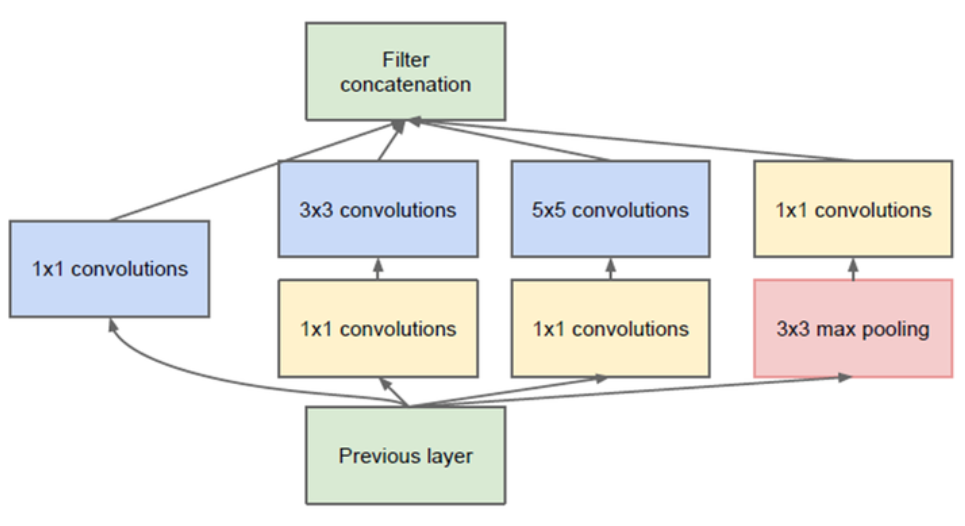

In [47]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red: dict, c_out: dict, act_fn):
        super().__init__()

        # 1x1
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]), act_fn())

        # 3x3
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]), act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]), act_fn())

        # 5x5
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]), act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]), act_fn())

        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]), act_fn())

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

In [49]:
class GoogLeNet(nn.Module):
    
    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                      act_fn_name=act_fn_name,
                                      act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
        
    def _create_network(self):
        
        # input
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        
        # Stacking inception block
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64,
                           c_red={"3x3":32,"5x5":16},
                           c_out={"1x1":16,"3x3":32,"5x5":8,"max":8},
                           act_fn=self.hparams.act_fn
                          ),
            InceptionBlock(64,
                           c_red={"3x3":32,"5x5":16},
                           c_out={"1x1":24,"3x3":48,"5x5":12,"max":12},
                           act_fn=self.hparams.act_fn
                          ),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(96,
                           c_red={"3x3":32,"5x5":16},
                           c_out={"1x1":24,"3x3":48,"5x5":12,"max":12},
                           act_fn=self.hparams.act_fn
                          ),
            InceptionBlock(96,
                           c_red={"3x3":32,"5x5":16},
                           c_out={"1x1":16,"3x3":48,"5x5":16,"max":16},
                           act_fn=self.hparams.act_fn
                          ),
            InceptionBlock(96,
                           c_red={"3x3":32,"5x5":16},
                           c_out={"1x1":16,"3x3":48,"5x5":16,"max":16},
                           act_fn=self.hparams.act_fn
                          ),
            InceptionBlock(96,
                           c_red={"3x3":32,"5x5":16},
                           c_out={"1x1":32,"3x3":48,"5x5":24,"max":24},
                           act_fn=self.hparams.act_fn
                          ),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(128,
                           c_red={"3x3":48,"5x5":16},
                           c_out={"1x1":32,"3x3":64,"5x5":16,"max":16},
                           act_fn=self.hparams.act_fn
                          ),
            InceptionBlock(128,
                           c_red={"3x3":48,"5x5":16},
                           c_out={"1x1":32,"3x3":64,"5x5":16,"max":16},
                           act_fn=self.hparams.act_fn
                          )
        )

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )
        
    def _init_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [50]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are : {str(model_dict.keys())}"
        
model_dict["GoogLeNet"] = GoogLeNet

In [51]:
act_fn_by_name = {
    "tanh" : nn.Tanh,
    "relu" : nn.ReLU,
    "leakyrelu" : nn.LeakyReLU,
    "gelu" : nn.GELU
}

In [62]:
import pytorch_lightning as pl


class CIFARModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name,
                 optimizer_hparmas):
        """
        model_name - Name of the model/CNN to run, Use create model
        model_hparams - Hyperparameters for the model, as dictionary
        optimizer_name - Name of the optimizer to use, Current option [Adam, SGD]
        optimizer_hparmas - Hpyerarameters for the optimizer, as dictionary
        """

        super().__init__()
        self.save_hyperparameters()  # Export hparmas to a YAML
        self.model = create_model(model_name, model_hparams)  # Create model
        self.loss_module = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeros((1, 3, 32, 32),
                                               dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):

        if self.hparams.optimizer_name == "Adam":
            optimizer = optim.AdamW(self.parameters(),
                                    **self.hparams.optimizer_hparmas)

        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(),
                                  **self.hparams.optimizer_hparmas)

        else:
            assert False, f"Unknown optimizer : \"{self.hparams.optimizer_name}\""
            
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log("train_acc", acc, on_step=False, on_epoch=True)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log("test_acc", acc)

In [76]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

def train_model(model_name, save_name=None, **kwargs):

    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # We run on a GPU (if possible)
                         devices=1,                                                                          # How many GPUs/CPUs we want to use (1 is enough for the notebooks)
                         max_epochs=180,                                                                     # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")],                                           # Log learning rate every epoch
                         enable_progress_bar=True)                                                           # Set to False if you do not want a progress bar
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = CIFARModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = CIFARModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [68]:
torch.set_float32_matmul_precision('medium')

googlenet_model, googlenet_results = train_model(model_name="GoogLeNet",
                                                model_hparams={"num_classes":10,
                                                              "act_fn_name": "relu"},
                                                optimizer_name="Adam",
                                                optimizer_hparmas={"lr":1e-3,
                                                                  "weight_decay":1e-4})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | In sizes       | Out sizes
------------------------------------------------------------------------------
0 | model       | GoogLeNet        | 260 K  | [1, 3, 32, 32] | [1, 10]  
1 | loss_module | CrossEntropyLoss | 0      | ?              | ?        
------------------------------------------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total params
1.043     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

PermissionError: [Errno 13] Permission denied: 'C:/Users/rh987/OneDrive/document/GitHub/AIFFEL/17_CNN_Backbone/saved_model/GoogLeNet/lightning_logs/version_0/hparams.yaml'

In [78]:
googlenet_results

{'test': 0.8633000254631042, 'val': 0.949999988079071}